2900 (100, 1)
13281 (100, 1)
load new pkl


Synthetic data generation: 100%|██████████| 104/104 [02:02<00:00,  1.17s/it]
C:\Users\po19996\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\po19996\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(13312, 100, 1)
Synthetic X train: (9960, 99, 1)
Real X train: (9960, 99, 1)
Synthetic y train: (9960, 1)
Real y train: (9960, 1)
Real X test: (3321, 99, 1)
Real y test: (3321, 1)
Epoch 1/200
78/78 [==============================] - 3s 21ms/step - loss: 0.2344 - val_loss: 0.1418
Epoch 2/200
78/78 [==============================] - 2s 20ms/step - loss: 0.0969 - val_loss: 0.0610
Epoch 3/200
78/78 [==============================] - 2s 20ms/step - loss: 0.0580 - val_loss: 0.0535
Epoch 4/200
78/78 [==============================] - ETA: 0s - loss: 0.051 - 2s 20ms/step - loss: 0.0516 - val_loss: 0.0491
Epoch 5/200
78/78 [==============================] - 2s 21ms/step - loss: 0.0481 - val_loss: 0.0461
Epoch 6/200
78/78 [==============================] - 2s 19ms/step - loss: 0.0453 - val_loss: 0.0441
Epoch 7/200
78/78 [==============================] - 2s 20ms/step - loss: 0.0428 - val_loss: 0.0430
Epoch 8/200
78/78 [==============================] - 2s 21ms/step - loss: 0.0412 - val_loss: 0.0

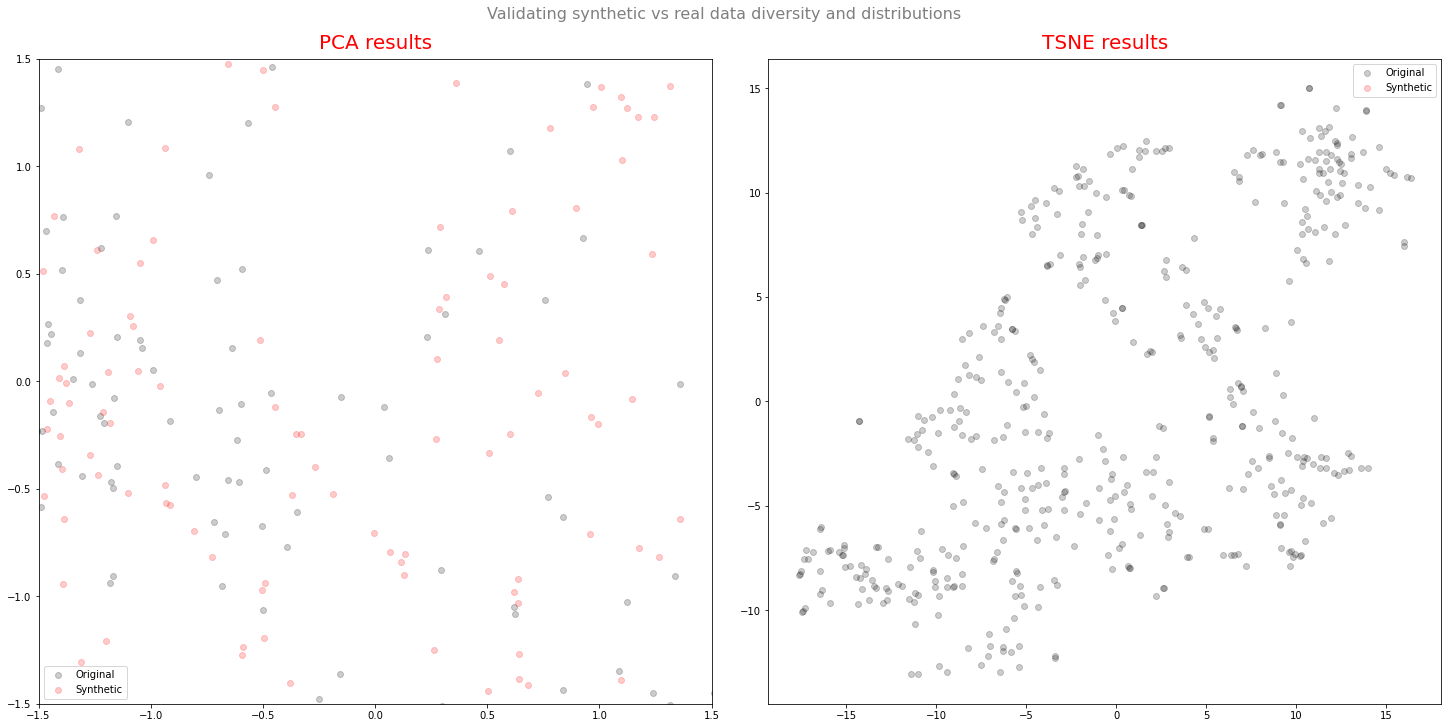

In [4]:
import os
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_synthetic.synthesizers.timeseries import TimeGAN
from ydata_synthetic.synthesizers import ModelParameters

# Specific to TimeGANs

seq_len = 100        # Timesteps
n_seq = 1          # Features

# Hidden units for generator (GRU & LSTM).
# Also decides output_units for generator
hidden_dim = 100

gamma = 1           # Used for discriminator loss

noise_dim = 32      # Used by generator as a starter dimension
dim = 128           # UNUSED
batch_size = 128

learning_rate = 5e-4
beta_1 = 0          # UNUSED
beta_2 = 1          # UNUSED
data_dim = 28       # UNUSED

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

#---------------------------------------------------------------------------------------------------------------------

from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading

file_path = ".../one_month.csv"
energy_df = pd.read_csv(file_path)

try:
    energy_df = energy_df.set_index('Date').sort_index()
except:
    energy_df = energy_df

# Data transformations to be applied prior to be used with the synthesizer model
energy_data = real_data_loading(energy_df.values, seq_len=seq_len)

print(len(energy_data), energy_data[0].shape)

file_path1 = ".../five_month.csv"
energy_df1 = pd.read_csv(file_path1)

try:
    energy_df1 = energy_df1.set_index('Date').sort_index()
except:
    energy_df1 = energy_df1

# Data transformations to be applied prior to be used with the synthesizer model
energy_data1 = real_data_loading(energy_df1.values, seq_len=seq_len)

print(len(energy_data1), energy_data1[0].shape)
#--------------------------------------------------------------------------------------------------------------------

if path.exists('test.pkl'):
    synth = TimeGAN.load('test.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
    print("load new pkl")
    synth.train(energy_data, train_steps=2000)
    synth.save('test.pkl')
    
synth_data = synth.sample(len(energy_data1))
print(synth_data.shape)
#print(synth_data)

#data = pd.DataFrame(synth_data)
#data.to_csv('output/GAN.csv')

#---------------------------------------------------------------------------------------------------------------

#cols = ["Q-factor(linear)"]

# Plotting some generated samples. Both Synthetic and Original data are still standardized with values between [0, 1]
#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
#axes=axes.flatten()

#time = list(range(1,101))
#obs = np.random.randint(len(energy_data))

#for j, col in enumerate(cols):
#    df = pd.DataFrame({'Real': energy_data[obs][:, j],
#                   'Synthetic': synth_data[obs][:, j]})
#    df.plot(ax=axes[j],
#            title = col,
#            secondary_y='Synthetic data', style=['-', '--'])
#fig.tight_layout()

#if not os.path.exists("img"):
#    os.makedirs("img")
#plt.savefig('C:/Users/po19996/OneDrive - University of Bristol/Desktop/GAN/img/comparison_gan_outputs.png', dpi=600)

#--------------------------------------------------------------------------------------------------------------------

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(energy_data))[:sample_size]

# Convert list to array, but taking only 250 random samples
# energy_data: (list(19711(ndarray(24, 28)))) -> real_sample: ndarray(250, 24, 28)
real_sample = np.asarray(energy_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

# For the purpose of comparison we need the data to be 2-Dimensional.
# For that reason we are going to use only two components for both the PCA and TSNE.
# synth_data_reduced: {ndarray: (7000, 24)}
# energy_data_reduced: {ndarray: (7000, 24)}
synth_data_reduced = real_sample.reshape(-1, seq_len)
energy_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

# The fit of the methods must be done only using the real sequential data
pca.fit(energy_data_reduced)

# pca_real: {DataFrame: (7000, 2)}
# pca_synth: {DataFrame: (7000, 2)}
pca_real = pd.DataFrame(pca.transform(energy_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

# data_reduced: {ndarray: (14000, 24)}
data_reduced = np.concatenate((energy_data_reduced, synth_data_reduced), axis=0)

# tsne_results: {DataFrame: (14000, 2)}
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

#-----------------------------------------------------------------------------------------------------------------

import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

# t-SNE scatter plot
plt.scatter(tsne_results.iloc[:7000, 0].values, tsne_results.iloc[:7000, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[7000:, 0], tsne_results.iloc[7000:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

if not os.path.exists("img"):
    os.makedirs("img")
plt.savefig('C:/Users/po19996/OneDrive - University of Bristol/Desktop/GAN/img/comparison_gan_output.png', dpi=600)

#-------------------------------------------------------------------------------------------------------------------

from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=1,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

#Prepare the dataset for the regression model
energy_data1=np.asarray(energy_data1)
synth_data = synth_data[:len(energy_data1)]
n_events = len(energy_data1)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]


X_energy_train = energy_data1[train_idx, :seq_len-1, :]
y_energy_train = energy_data1[train_idx, -1, :]

X_synth_train = synth_data[train_idx, :seq_len-1, :]
y_synth_train = synth_data[train_idx, -1, :]

X_energy_test = energy_data1[test_idx, :seq_len-1, :]
y_energy_test = energy_data1[test_idx, -1, :]


print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_energy_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_energy_train.shape))

print('Real X test: {}'.format(X_energy_test.shape))
print('Real y test: {}'.format(y_energy_test.shape))

#------------------------------------------------------------------------------------------------------------------------

#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_energy_train,
                          y=y_energy_train,
                          validation_data=(X_energy_test, y_energy_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_energy_test, y_energy_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_energy_test)
synth_predictions = ts_synth.predict(X_energy_test)
print(y_energy_test.shape)
print(real_predictions.shape)
print(synth_predictions.shape)
metrics_dict = {'r2': [r2_score(y_energy_test, real_predictions),
                       r2_score(y_energy_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_energy_test, real_predictions),
                        mean_absolute_error(y_energy_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_energy_test, real_predictions),
                         mean_squared_log_error(y_energy_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])
print(results)
#results.to_csv('output/GAN.csv')
